In [85]:
import xarray as xr
import rioxarray # for the .rio functions
import matplotlib.pyplot as plt
import numpy as np

from pyproj import Transformer
from scipy.interpolate import griddata
## import cartopy for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [86]:
ds_smb = xr.open_dataset("SMB_2016_ready.nc")
ds_smb

<xarray.Dataset> Size: 5MB
Dimensions:    (TIME: 1, bnds: 2, X7_533: 527, Y7_553: 547, SECTOR: 2)
Coordinates:
  * TIME       (TIME) datetime64[ns] 8B 2016-07-02
  * X7_533     (X7_533) float32 2kB -3.212e+03 -3.2e+03 ... 3.35e+03 3.362e+03
  * Y7_553     (Y7_553) float32 2kB -3.162e+03 -3.15e+03 ... 3.65e+03 3.662e+03
  * SECTOR     (SECTOR) float32 8B 1.0 2.0
    LAT        (Y7_553, X7_533) float32 1MB ...
    LON        (Y7_553, X7_533) float32 1MB ...
Dimensions without coordinates: bnds
Data variables:
    TIME_bnds  (TIME, bnds) datetime64[ns] 16B ...
    SMB        (TIME, SECTOR, Y7_553, X7_533) float32 2MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institute:    University of Li�ge (Belgium)
    contact:      clara.lambin@uliege.be
    model:        regional climate model MARv3.12
    frequency:    year
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...
    history:      Tue Dec 10 14:17:48 2024: ncatted -O -a coordinates,SMB,a,c...
    NCO:          netCDF Operators version 4.9.1 (Homepage = http://nco.sf.ne...

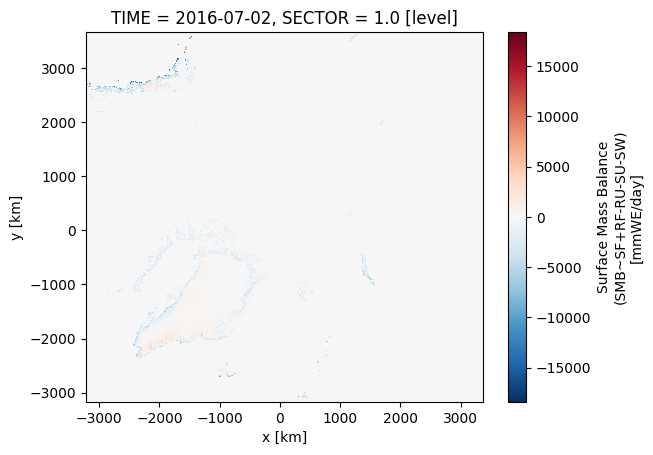

In [87]:
ds_smb['SMB'].isel(TIME = 0,SECTOR = 0).plot()

In [88]:
ds_sec = xr.open_dataset("CCI_GrIS_RA_SEC_5km_Vers3.0_2021-08-09.nc")
ds_sec


<xarray.Dataset> Size: 42MB
Dimensions:     (x: 325, y: 614, t: 25)
Coordinates:
  * x           (x) float32 1kB -7.393e+05 -7.343e+05 ... 8.757e+05 8.807e+05
  * y           (y) float32 2kB -3.478e+06 -3.473e+06 ... -4.181e+05 -4.131e+05
    time        (t) datetime64[ns] 200B ...
Dimensions without coordinates: t
Data variables:
    Start_time  (t) datetime64[ns] 200B ...
    End_time    (t) datetime64[ns] 200B ...
    crs         |S1 1B ...
    lat         (y, x) float32 798kB ...
    lon         (y, x) float32 798kB ...
    SEC         (y, x, t) float32 20MB ...
    SECer       (y, x, t) float32 20MB ...
Attributes: (12/49)
    Title:                     Surface elevation change of the Greenland ice ...
    institution:               DTU Space (GEO) for ESA Greenland CCI+
    references:                Simonsen and Sørensen (2017), Sørensen et al. ...
    source:                    ERS-1, ERS-2, ENVISAT, CRYOSAT-2, SENTINEL-3A/B
    history:                   b'commit 8bb1406e796b4916c2e5585245634562cd02b...
    id:                        CCI_GrIS_RA_SEC_5km_Vers3.0_2021-08-09.nc
    ...                        ...
    naming_authority:          DTU space
    cdm_data_type:             Grid
    key_variables:             SEC, SECer
    keywords:                  EARTH SCIENCE CRYOSPHERE GLACIERS/ICE SHEETS/G...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   Surface elevation change rate derived for Gree...

In [89]:
transformer = Transformer.from_crs(4326, 3572, always_xy=True)
transformer

<Concatenated Operation Transformer: pipeline>
Description: axis order change (2D) + North Pole Lambert Azimuthal Equal Area (Alaska)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)

In [90]:
x_smb_reprojected, y_smb_reprojected = transformer.transform(ds_smb.LON, ds_smb.LAT)


aspect_smb = ds_smb.Y7_553.size / ds_smb.X7_533.size
nx_smb = 400
ny_smb = int(nx_smb * aspect_smb)
shape = (1, ny_smb, nx_smb)

x_target = np.linspace(x_smb_reprojected.min(), x_smb_reprojected.max(), nx_smb)
y_target = np.linspace(y_smb_reprojected.min(), y_smb_reprojected.max(), ny_smb)[::-1]
X_target, Y_target = np.meshgrid(x_target, y_target)




regridded_data_smb = griddata(
list(zip(x_smb_reprojected.ravel(), y_smb_reprojected.ravel())),
ds_smb['SMB'].isel(TIME = 0).isel(SECTOR = 0).to_numpy().ravel(),
list(zip(X_target.ravel(), Y_target.ravel())),
method='linear',
)
regridded_data_smb = regridded_data_smb.reshape(shape)




In [91]:
x_sec_reprojected, y_sec_reprojected = transformer.transform(ds_sec.lon, ds_sec.lat)

regridded_data_sec = griddata(
list(zip(x_sec_reprojected.ravel(), y_sec_reprojected.ravel())),
ds_sec['SEC'].isel(t = -3).to_numpy().ravel(),
list(zip(X_target.ravel(), Y_target.ravel())),
method='linear',
)
regridded_data_sec = regridded_data_sec.reshape(shape)



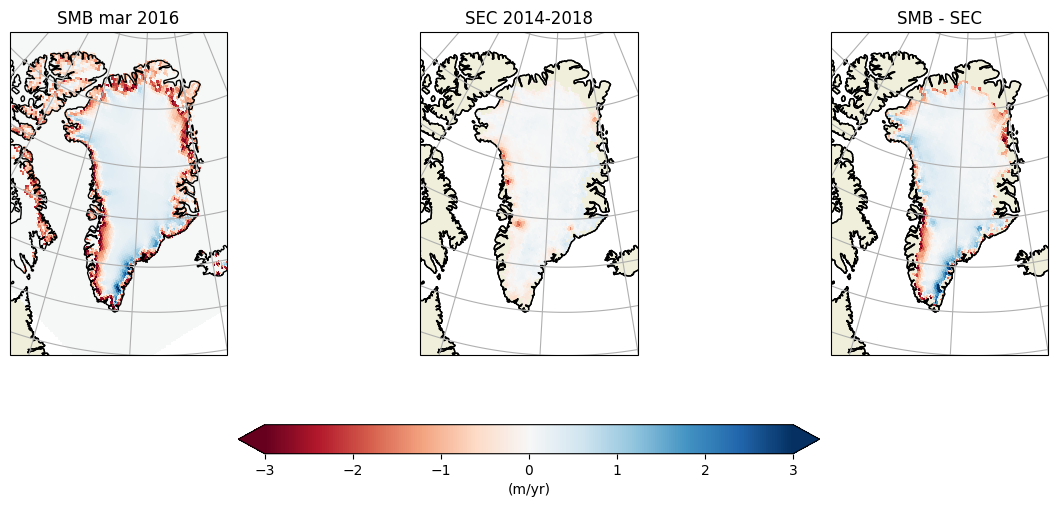

In [94]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 6), subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-35, central_latitude=80)})
axs[0].set_extent([-65, -20, 55, 85], ccrs.PlateCarree())
axs[1].set_extent([-65, -20, 55, 85], ccrs.PlateCarree())
axs[2].set_extent([-65, -20, 55, 85], ccrs.PlateCarree())
# coastlines and land features
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.gridlines()

#plotting the data
vmin =-3
vmax = 3
p = axs[0].pcolormesh(X_target, Y_target, regridded_data_smb[0]*1e-3, transform=ccrs.epsg(3572), vmin=vmin, vmax=vmax,cmap = 'RdBu')
axs[1].pcolormesh(X_target, Y_target, regridded_data_sec[0], transform=ccrs.epsg(3572), vmin=vmin, vmax=vmax,cmap = 'RdBu')
axs[2].pcolormesh(X_target, Y_target, regridded_data_smb[0]*1e-3 - regridded_data_sec[0], transform=ccrs.epsg(3572), vmin=vmin, vmax=vmax,cmap = 'RdBu')


## titles 
axs[0].set_title('SMB mar 2016')
axs[1].set_title('SEC 2014-2018')
axs[2].set_title('SMB - SEC')
##colorbar
fig.colorbar(p, ax=axs, orientation='horizontal', label='(m/yr)', shrink=0.5, extend='both')
plt.savefig('SMB_SEC.png')